# 토픽 모델링

-https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [24]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
import collections
import gensim
from gensim import models, corpora
from gensim.models import CoherenceModel, Phrases
import pyLDAvis 
import pyLDAvis.gensim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from konlpy.tag import Okt
import logging
import hanja
from krwordrank.hangle import normalize
import datetime
%matplotlib inline

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
gender = pd.read_csv('whole-gender-bill-1320.csv', index_col=0,
                           parse_dates=['제안일자','의결일자'],encoding='utf-8-sig')
print(gender.shape)
gender.head(1)

(4521, 16)


/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자,발의자,제안정당,성별,여성의원 수,정당성향,국회회기
0,131131,소득세법중개정법률안,1990-12-17,위원장,1990-12-18,원안가결,제13대 (1988~1992) 제151회,"정부제출,柳인학·강金식·금봉욱·林춘원·李경재·허만기·홍영기의원외64인 발의,1...",재무위원회,[],위원장,위원장,NaN,0,NaN,13


In [4]:
gender['제안일자'] = gender['제안일자'].dt.date
gender['의결일자'] = gender['의결일자'].dt.date

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
gender['제안일자'].unique()

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([datetime.date(1990, 12, 17), datetime.date(1990, 11, 20),
       datetime.date(1990, 10, 8), ..., datetime.date(2016, 6, 1),
       datetime.date(2016, 5, 31), datetime.date(2016, 5, 30)],
      dtype=object)

In [6]:
drop_list = [177919, 177064, 176854, 176797, 176796, 176795, 176794]

gender = gender[~gender['의안번호'].isin(drop_list)]
gender.shape

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(4514, 16)

## 정부별 wordcloud

In [7]:
gender['제안자구분'].value_counts()

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


의원     3992
위원장     344
정부      178
Name: 제안자구분, dtype: int64

In [8]:
# 한글 전처리
def preprocessing(text): 
    text_pre1 = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text_pre2 = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text_pre1)
    return str(text_pre2)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지','일명','보장하',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
              '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등',\
              '안','바','이','것','부터','수','시','자','만원이하',
            '조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','의결','현행','본회','시행','조사','위원회','천만원',
            '의결제','조정','인정','국회','억원','부칙','본회의','제안','도지사','대통령령','감사','내용','제한','요청','통신','목적','발의',
            '가액','기준','승인','우리','결과','법률안','협의','제출']

    text = [word for word in text if word not in stopwords]
    return text

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
%time gender['의안텍스트'] = gender['의안텍스트'].apply(preprocessing)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 299 ms, sys: 4.16 ms, total: 303 ms
Wall time: 323 ms


In [11]:
from konlpy.tag import Mecab, Okt, Hannanum

# okt = Okt()
hannanum = Hannanum()

def get_tokens(x):
    try:
        return [i for i in hannanum.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 3min 2s, sys: 1.69 s, total: 3min 4s
Wall time: 2min 45s


0    [소득세법중개정법률, 정부제출, 인학, 금봉욱, 춘원, 경재, 허만기, 홍영기의원외...
1    [특정범죄가중처벌등에관한법률중개정법률안, 정부, 제출, 특정범죄, 가중처벌, 법률,...
2    [유아의보호, 교육에관한법률안, 현대사회, 산업화, 여성, 사회참여, 가족구조, 핵...
Name: tokens, dtype: object

In [13]:
%time gender['tokens'] = gender['tokens'].apply(remove_stopword)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 1.47 s, sys: 12.1 ms, total: 1.48 s
Wall time: 1.53 s


In [14]:
%time gender['명사수'] = gender['tokens'].apply(len)

CPU times: user 1.96 ms, sys: 72 µs, total: 2.03 ms
Wall time: 1.98 ms


/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
# 명사 수가 10개를 넘어가는 경우만 추출
gender = gender[gender['명사수'] >= 1]
gender = gender.reset_index(drop=True)
print(gender.shape)

(4514, 19)


/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 정권 탐색 

### 노태우 정권 
- 1998.02.25 ~ 1993.02.24

In [70]:
def remove_stopword(text): 
    stopwords = ['항제','한편','특정','계산시','원안폐','만원이하','현재','신설','적용','퍼센트','다음','미만','보고','이유','인상함','연간','조등','도모']

    text = [word for word in text if word not in stopwords]
    return text

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
notaewoo = gender[(gender['제안일자'] > datetime.date(1988,5,3)) & 
                        (gender['제안일자'] < datetime.date(1993,2,24))]
notaewoo.shape

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(23, 19)

In [72]:
notaewoo['tokens'] = notaewoo['tokens'].apply(remove_stopword)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-72-95dba1be21f7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  notaewoo['tokens'] = notaewoo['tokens'].apply(remove_stopword)


In [73]:
data = notaewoo['tokens'].values.tolist()

id2word = corpora.Dictionary(data) 
texts = data
corpus = [id2word.doc2bow(text) for text in texts]

#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
id2word = corpora.Dictionary(data) 
texts = data
corpus = [id2word.doc2bow(text) for text in texts]



/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=5,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.016*"징역" + 0.016*"무기" + 0.011*"유기징역" + 0.010*"사형" + 0.009*"가중처벌" + 0.008*"강간" + 0.007*"처벌" + 0.007*"범죄" + 0.007*"모자가정" + 0.007*"피해자"'), (1, '0.017*"후보자" + 0.012*"정당" + 0.009*"선거구" + 0.007*"지방자치단체" + 0.007*"강력범죄" + 0.006*"공제" + 0.004*"규정함" + 0.004*"지방의회의원" + 0.004*"지역선거구" + 0.004*"선거"'), (2, '0.012*"배우자" + 0.012*"호주" + 0.010*"가정법원" + 0.009*"부부" + 0.006*"후견인" + 0.005*"가족법" + 0.005*"직계비속" + 0.005*"부모" + 0.005*"상속분" + 0.005*"사회"'), (3, '0.021*"공제" + 0.015*"소득세" + 0.013*"근로자" + 0.013*"과세" + 0.011*"세부담" + 0.010*"세율" + 0.009*"경감" + 0.009*"지급" + 0.008*"상향조정" + 0.007*"과세표준"'), (4, '0.010*"보육시설" + 0.007*"보호" + 0.007*"범죄" + 0.007*"여성" + 0.007*"지방자치단체" + 0.006*"성폭력범죄" + 0.006*"형법" + 0.006*"처벌" + 0.006*"보호감호" + 0.005*"시설"')]


/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.107683  0.067201       1        1  29.287743
2      0.040128 -0.180623       2        1  22.730782
3     -0.184707  0.024286       3        1  20.736050
0      0.061900  0.077397       4        1  15.688570
1     -0.025003  0.011738       5        1  11.556856, topic_info=    Term       Freq      Total Category  logprob  loglift
12    공제  22.000000  22.000000  Default  30.0000  30.0000
80   소득세  13.000000  13.000000  Default  29.0000  29.0000
160   무기  10.000000  10.000000  Default  28.0000  28.0000
683  후보자   8.000000   8.000000  Default  27.0000  27.0000
202   징역  11.000000  11.000000  Default  26.0000  26.0000
..   ...        ...        ...      ...      ...      ...
632   자유   1.129161   3.106103   Topic5  -6.0544   1.1460
373   간음   1.129091   5.106718   Topic5  -6.0544   0.6487
410  상습범   1.128511   5.244485   Topic5  -6.0550   0.6216
465   특례   1.128182   3.901889   Topic5  -6.0553   0.9170
142   강간   1.127939   7.815448   Topic5  -6.0555   0.2222

[262 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
688       2  0.936489    가정법원
221       1  0.695806  가정보육시설
689       2  0.976837      가족
690       2  0.913639     가족법
138       1  0.351381    가중처벌
...     ...       ...     ...
218       4  0.842463      휴대
218       5  0.280821      휴대
219       4  0.842571      흉기
219       5  0.280857      흉기
2122      1  0.695991      흡수

[316 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 1, 2])

## 김영삼 정권 
- 1993.02.25 ~ 1998.02.24

In [38]:
kimyoungsam = gender[(gender['제안일자'] > datetime.date(1993,2,25)) & 
                        (gender['제안일자'] < datetime.date(1998,2,24))]
kimyoungsam.shape

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(62, 19)

In [39]:
kimyoungsam_clean = kimyoungsam['tokens']

kimyoungsam_commoncount, kimyoungsam_commondict = check_common(kimyoungsam_clean)
kimyoungsam_commoncount

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('피해자', 70),
 ('보호', 63),
 ('지방자치단체', 61),
 ('신설', 57),
 ('여성', 54),
 ('가정폭력', 51),
 ('청소년', 48),
 ('강화', 42),
 ('가정', 35),
 ('국가', 34),
 ('근로자', 31),
 ('지원', 28),
 ('범위', 26),
 ('규정함', 25),
 ('보완', 25),
 ('성폭력범죄', 25),
 ('예방', 24),
 ('퍼센트', 24),
 ('보호처분', 24),
 ('보육시설', 22)]

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
coh: 100%|██████████| 18/18 [00:29<00:00,  1.66s/it]


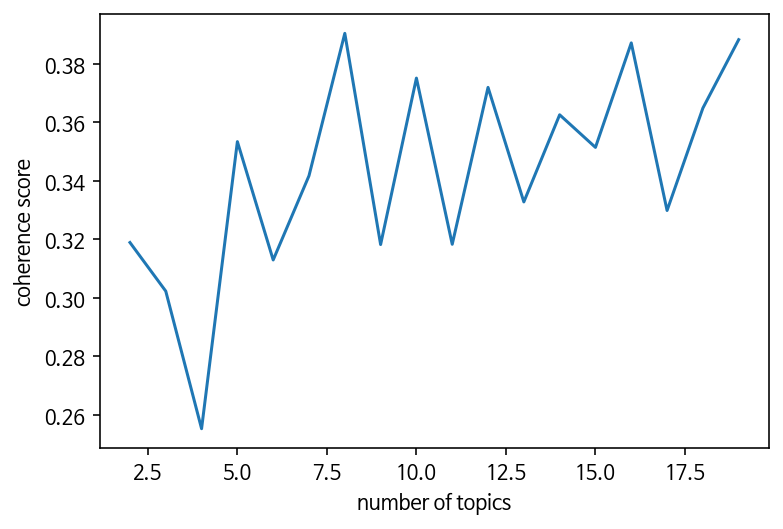

perp: 100%|██████████| 18/18 [00:03<00:00,  4.76it/s]
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


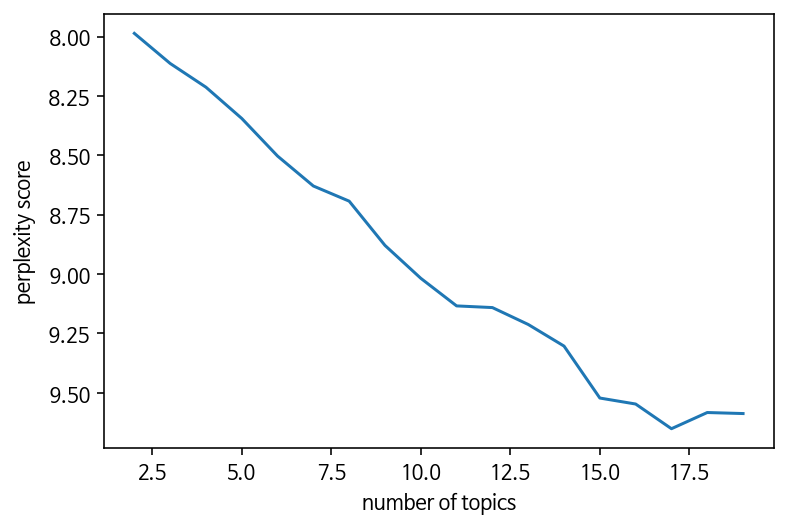

In [40]:
# 말뭉치 만들기 
kimyoungsam_corpus, kimyoungsam_dictionary, kimyoungsam_cleanlist = make_corpus(kimyoungsam_clean)

# 토픽수 결정 
coh_visual(kimyoungsam_corpus, kimyoungsam_dictionary, kimyoungsam_cleanlist)
perp_visual(kimyoungsam_corpus, kimyoungsam_dictionary)

In [41]:
# 토픽모델링 - 사이킷런 LDA 
kimyoungsam_clean_flat = []

for i in kimyoungsam_clean: 
    for j in i: 
        kimyoungsam_clean_flat.append(j)

kimyoungsam_count_vect = CountVectorizer(max_df = 1.0, 
                                     max_features=1000, 
                                     min_df=10, 
                                     ngram_range=(1,2))
kimyoungsam_fit_vect = kimyoungsam_count_vect.fit_transform(kimyoungsam_clean_flat)

kimyoungsam_lda = LatentDirichletAllocation(n_components=6, random_state=0)
kimyoungsam_lda.fit(kimyoungsam_fit_vect)

kimyoungsam_feature_names = kimyoungsam_count_vect.get_feature_names()

display_topics(kimyoungsam_lda, kimyoungsam_feature_names, 15)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic # 0
가정폭력 가정 국가 처벌 위반 정부 추진 직장내 규제 업무 부과 상담소 성희롱 적용 교육
Topic # 1
청소년 보호처분 남녀평등 한편 확보 근거 사업주 아동 강간 법안심사소위원회 금지 발전 보조 치료 국적
Topic # 2
여성 보완 퍼센트 문제 청소년유해매체물 가정보호사건 개편 수립 제공 미비점 남녀 실질적 세미만 사회복지 우려
Topic # 3
피해자 신설 근로자 지원 기능 확대 징역 차별 도모 의무 검사 촉진 자녀 미성년자 종전
Topic # 4
보호 강화 범위 보육시설 실효성 사회 결정 행위자 통합 사회적 성폭력 보호시설 퇴직 처리 폭력
Topic # 5
지방자치단체 성폭력범죄 규정함 예방 회부 각종 항제 유치원 추가 청소년보호위원회 부담 심사 매체물 대안 청소년보호


## 김대중 정권 
- 1998.02.25 ~ 2003.02.24

In [43]:
kimdaejoong = gender[(gender['제안일자'] > datetime.date(1998,2,25)) & 
                        (gender['제안일자'] < datetime.date(2003,2,24))]
kimdaejoong.shape

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(92, 19)

In [44]:
kimdaejoong_clean = kimdaejoong['tokens']

kimdaejoong_commoncount, kimdaejoong_commondict = check_common(kimdaejoong_clean)
kimdaejoong_commoncount

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('청소년', 177),
 ('신설', 130),
 ('아동', 115),
 ('여성', 99),
 ('행위', 80),
 ('피해자', 51),
 ('보호', 50),
 ('확대', 50),
 ('지방자치단체', 49),
 ('정당', 47),
 ('대상', 45),
 ('강화', 44),
 ('근로자', 44),
 ('지원', 42),
 ('수립', 38),
 ('지급', 37),
 ('보육시설', 35),
 ('처벌', 32),
 ('보완', 32),
 ('규정함', 30)]

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
coh: 100%|██████████| 18/18 [00:30<00:00,  1.70s/it]


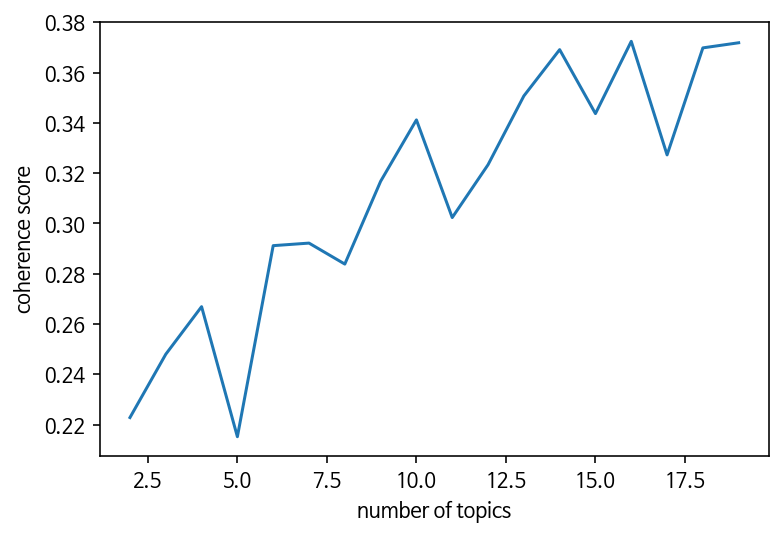

perp: 100%|██████████| 18/18 [00:05<00:00,  3.46it/s]


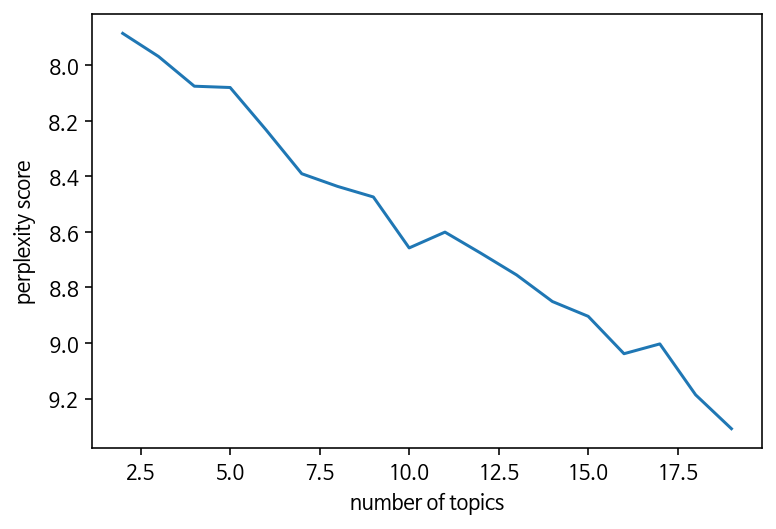

In [45]:
# 말뭉치 만들기 
kimdaejoong_corpus, kimdaejoong_dictionary, kimdaejoong_cleanlist = make_corpus(kimdaejoong_clean)

# 토픽수 결정 
coh_visual(kimdaejoong_corpus, kimdaejoong_dictionary, kimdaejoong_cleanlist)
perp_visual(kimdaejoong_corpus, kimdaejoong_dictionary)

In [46]:
# 토픽모델링 - 사이킷런 LDA 
kimdaejoong_clean_flat = []

for i in kimdaejoong_clean: 
    for j in i: 
        kimdaejoong_clean_flat.append(j)

kimdaejoong_count_vect = CountVectorizer(max_df = 1.0, 
                                     max_features=1000, 
                                     min_df=10, 
                                     ngram_range=(1,2))
kimdaejoong_fit_vect = kimdaejoong_count_vect.fit_transform(kimdaejoong_clean_flat)

kimdaejoong_lda = LatentDirichletAllocation(n_components=6, random_state=0)
kimdaejoong_lda.fit(kimdaejoong_fit_vect)

kimdaejoong_feature_names = kimdaejoong_count_vect.get_feature_names()

display_topics(kimdaejoong_lda, kimdaejoong_feature_names, 15)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic # 0
청소년 신설 확대 회부 범위 대안 알선 제작 검사 공중화장실 과학기술 구청장 사회적 평가 용음란물
Topic # 1
정당 대상 보육시설 보완 금지 수행 행위자 정책 보호처분 부의 사회 한편 미비점 성매매행위 사유
Topic # 2
보호 근로자 지원 수정 정부 제공 추가 도모 임신 효율적 범죄 휴직기간 미만 자녀 여성정책
Topic # 3
행위 피해자 강화 처벌 성희롱 육아휴직 추진 추천 확보 보육 위반 사용 사업주 도입 시책
Topic # 4
지방자치단체 지급 규정함 국가 휴직 제도 실질적 종전 법원 실효성 분야 강요 촉진 신청 산전후
Topic # 5
아동 여성 수립 공무원 교육 개선 법안심사소위원회 공공기관 적용 여성기업 업무 활동 항제 결정 처리


## 노무현 정권  
- 2003.02.25 ~ 2004.04.14

In [48]:
romoohyun = gender[(gender['제안일자'] > datetime.date(2003,2,25)) & 
                        (gender['제안일자'] < datetime.date(2008,2,24))]
romoohyun.shape

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(447, 19)

In [49]:
romoohyun_clean = romoohyun['tokens']

romoohyun_commoncount, romoohyun_commondict = check_common(romoohyun_clean)
romoohyun_commoncount

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('신설', 698),
 ('지원', 370),
 ('피해자', 323),
 ('지방자치단체', 318),
 ('보호', 292),
 ('여성', 244),
 ('근로자', 229),
 ('자녀', 216),
 ('청소년', 212),
 ('국가', 205),
 ('확대', 201),
 ('항제', 187),
 ('행위', 185),
 ('지급', 184),
 ('보육시설', 182),
 ('강화', 175),
 ('장애', 168),
 ('출산', 166),
 ('범위', 162),
 ('처벌', 156)]

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
coh: 100%|██████████| 18/18 [01:07<00:00,  3.74s/it]


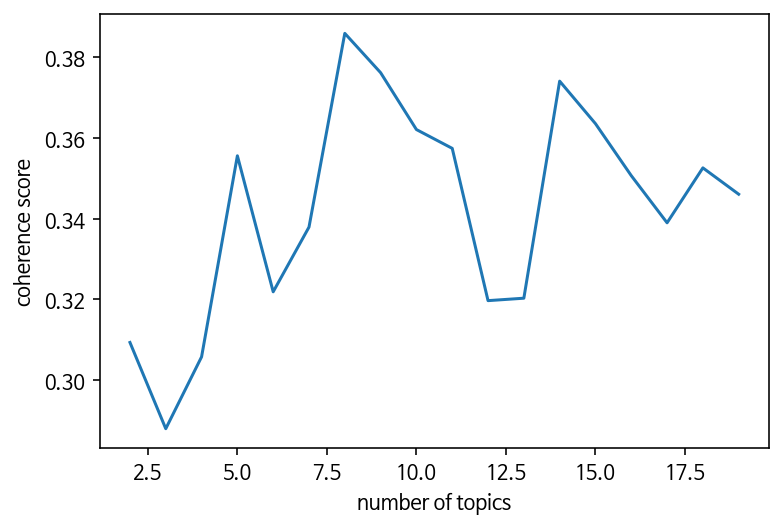

perp: 100%|██████████| 18/18 [00:24<00:00,  1.34s/it]


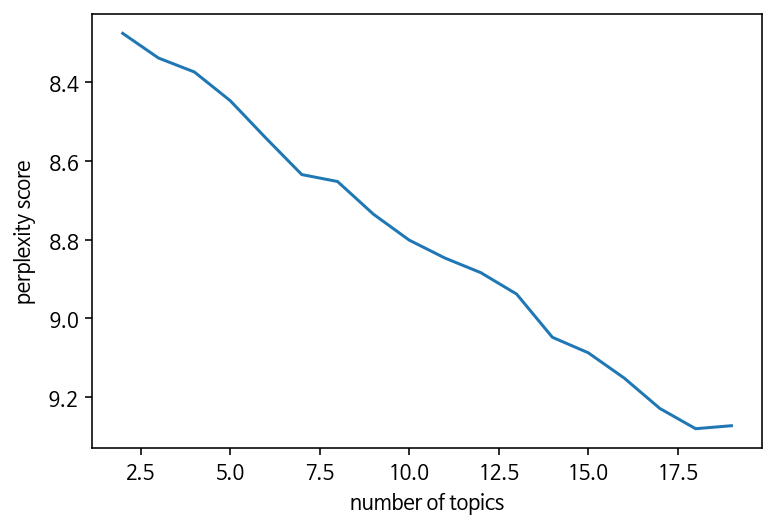

In [50]:
# 말뭉치 만들기 
romoohyun_corpus, romoohyun_dictionary, romoohyun_cleanlist = make_corpus(romoohyun_clean)

# 토픽수 결정 
coh_visual(romoohyun_corpus, romoohyun_dictionary, romoohyun_cleanlist)
perp_visual(romoohyun_corpus, romoohyun_dictionary)

In [51]:
# 토픽모델링 - 사이킷런 LDA 
romoohyun_clean_flat = []

for i in romoohyun_clean: 
    for j in i: 
        romoohyun_clean_flat.append(j)

romoohyun_count_vect = CountVectorizer(max_df = 1.0, 
                                     max_features=1000, 
                                     min_df=10, 
                                     ngram_range=(1,2))
romoohyun_fit_vect = romoohyun_count_vect.fit_transform(romoohyun_clean_flat)

romoohyun_lda = LatentDirichletAllocation(n_components=6, random_state=0)
romoohyun_lda.fit(romoohyun_fit_vect)

romoohyun_feature_names = romoohyun_count_vect.get_feature_names()

display_topics(romoohyun_lda, romoohyun_feature_names, 15)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic # 0
지방자치단체 근로자 자녀 강화 추가 대안 부담 도입 한편 규정함 근거 개선 문제 성매매 대표발의
Topic # 1
지원 장애 수립 성폭력범죄 육아휴직 업무 사회 교육 관리 사업 경제적 수용자 미비점 사업장 불구
Topic # 2
피해자 보육시설 대상 적용 수행 제도 장애인 가정 비용 법원 효율적 시책 확보 결정 구청장
Topic # 3
범위 사용 국민 사회적 미만 임신 영유아 저출산 이유 예방 양육 보완 육아 사업주 위반
Topic # 4
보호 항제 행위 지급 차별 변경 제공 청구 범죄 성범죄 사유 여성가족부장관 처우 공무원 성별
Topic # 5
신설 여성 청소년 국가 확대 출산 처벌 아동 시설 정부 고용 법안심사소위원회 지정 이내 방지


## 이명박 정권
- 2008.02.25 ~ 2013.02.24

In [52]:
leemyungbak = gender[(gender['제안일자'] > datetime.date(2008,2,25)) & 
                        (gender['제안일자'] < datetime.date(2013,2,24))]
leemyungbak.shape

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1131, 19)

In [53]:
leemyungbak_clean = leemyungbak['tokens']

leemyungbak_commoncount, leemyungbak_commondict = check_common(leemyungbak_clean)
leemyungbak_commoncount

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('아동', 1345),
 ('신설', 1323),
 ('청소년', 953),
 ('지원', 827),
 ('피해자', 688),
 ('처벌', 683),
 ('성범죄', 636),
 ('성폭력범죄', 562),
 ('보호', 545),
 ('대상', 523),
 ('여성', 477),
 ('성폭력', 439),
 ('국가', 427),
 ('지방자치단체', 425),
 ('자녀', 415),
 ('범죄', 391),
 ('제공', 386),
 ('근로자', 346),
 ('확대', 338),
 ('지급', 337)]

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
coh: 100%|██████████| 18/18 [01:34<00:00,  5.25s/it]


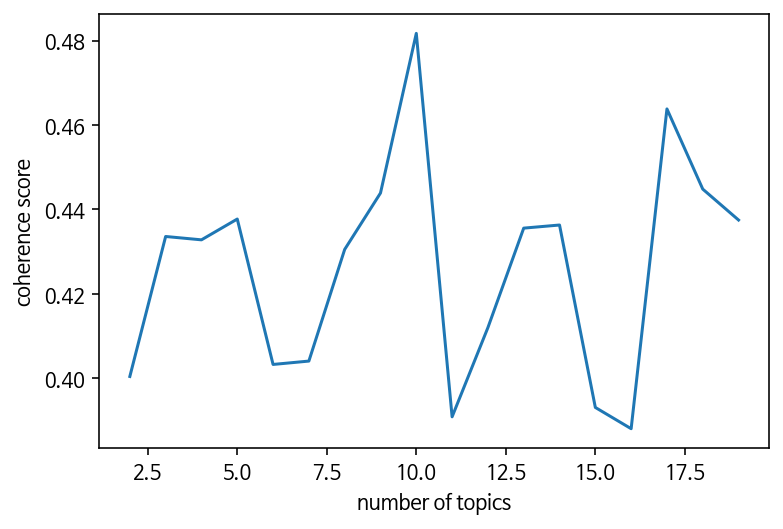

perp: 100%|██████████| 18/18 [00:57<00:00,  3.18s/it]


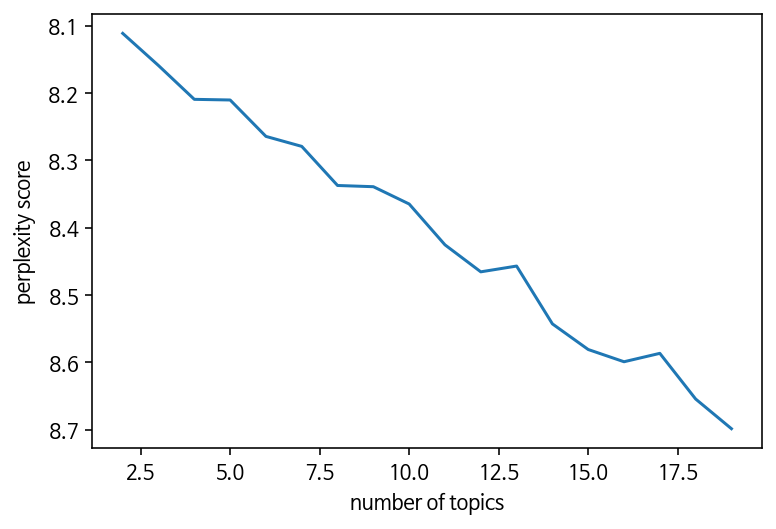

In [54]:
# 말뭉치 만들기 
leemyungbak_corpus, leemyungbak_dictionary, leemyungbak_cleanlist = make_corpus(leemyungbak_clean)

# 토픽수 결정 
coh_visual(leemyungbak_corpus, leemyungbak_dictionary, leemyungbak_cleanlist)
perp_visual(leemyungbak_corpus, leemyungbak_dictionary)

In [55]:
# 토픽모델링 - 사이킷런 LDA 
leemyungbak_clean_flat = []

for i in leemyungbak_clean: 
    for j in i: 
        leemyungbak_clean_flat.append(j)

leemyungbak_count_vect = CountVectorizer(max_df = 1.0, 
                                     max_features=1000, 
                                     min_df=10, 
                                     ngram_range=(1,2))
leemyungbak_fit_vect = leemyungbak_count_vect.fit_transform(leemyungbak_clean_flat)

leemyungbak_lda = LatentDirichletAllocation(n_components=6, random_state=0)
leemyungbak_lda.fit(leemyungbak_fit_vect)

leemyungbak_feature_names = leemyungbak_count_vect.get_feature_names()

display_topics(leemyungbak_lda, leemyungbak_feature_names, 15)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic # 0
범죄 행위 예방 성보호 사용 미성년자 방지 보육 법원 변경 도입 전자장치 실효성 청구 수립
Topic # 1
아동 피해자 성폭력범죄 지급 대표발의 대안 국민 강화 어린이집 한편 미만 가정폭력 추가 다문화가족 수준
Topic # 2
지원 대상 근로자 가정 범위 이유 영유아 불구 특례법 형법 확보 육아휴직 피해자보호 위반 비용
Topic # 3
신설 보호 성폭력 국가 제공 문제 저출산 증가 사회 양육 가족 사업주 치료 어려움 영유아보육법
Topic # 4
청소년 처벌 성범죄 여성 출산 항제 사회적 제도 성범죄자 임신 시설 장애 차별 징역 고용
Topic # 5
지방자치단체 자녀 확대 교육 양육비 신상정보 보육시설 근거 적용 부담 표현 청소년대상 관리 우리나라 정보


## 박근혜 정권
- 2013.02.25 ~ 2017.03.13

In [56]:
parkkeunhye = gender[(gender['제안일자'] > datetime.date(2013,2,25)) & 
                        (gender['제안일자'] < datetime.date(2017,5,10))]
parkkeunhye.shape

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1121, 19)

In [57]:
parkkeunhye_clean = parkkeunhye['tokens']

parkkeunhye_commoncount, parkkeunhye_commondict = check_common(parkkeunhye_clean)
parkkeunhye_commoncount

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('지원', 1129),
 ('신설', 956),
 ('여성', 687),
 ('아동', 632),
 ('피해자', 622),
 ('청소년', 569),
 ('보호', 567),
 ('근로자', 535),
 ('지방자치단체', 468),
 ('자녀', 422),
 ('국가', 393),
 ('처벌', 365),
 ('가정', 356),
 ('어린이집', 353),
 ('문제', 341),
 ('성희롱', 335),
 ('성범죄', 325),
 ('대상', 303),
 ('범죄', 301),
 ('출산', 299)]

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
coh: 100%|██████████| 18/18 [01:26<00:00,  4.83s/it]


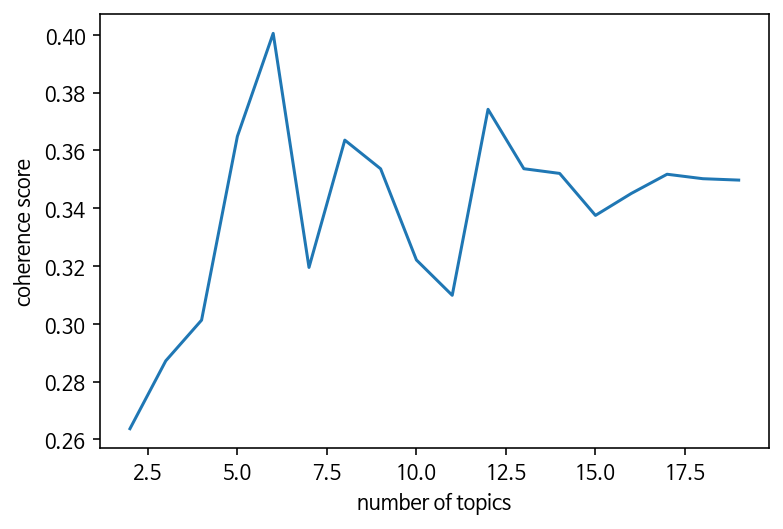

perp: 100%|██████████| 18/18 [00:48<00:00,  2.70s/it]


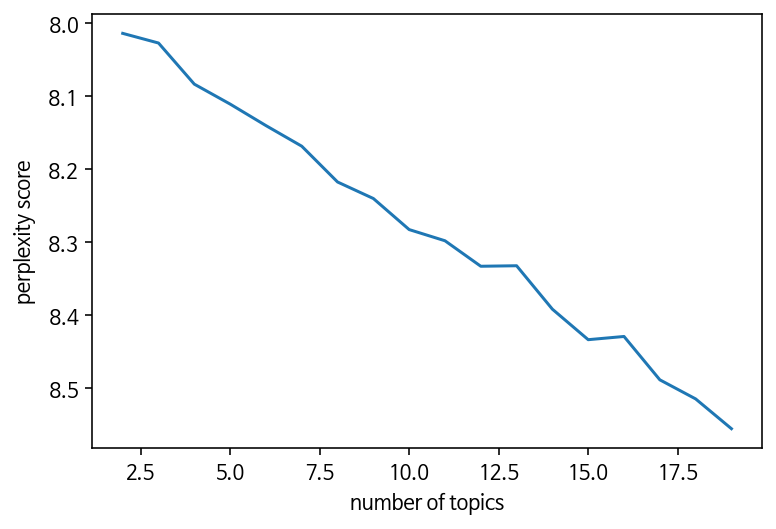

In [58]:
# 말뭉치 만들기 
parkkeunhye_corpus, parkkeunhye_dictionary, parkkeunhye_cleanlist = make_corpus(parkkeunhye_clean)

# 토픽수 결정 
coh_visual(parkkeunhye_corpus, parkkeunhye_dictionary, parkkeunhye_cleanlist)
perp_visual(parkkeunhye_corpus, parkkeunhye_dictionary)

In [59]:
# 토픽모델링 - 사이킷런 LDA 
parkkeunhye_clean_flat = []

for i in parkkeunhye_clean: 
    for j in i: 
        parkkeunhye_clean_flat.append(j)

parkkeunhye_count_vect = CountVectorizer(max_df = 1.0, 
                                     max_features=1000, 
                                     min_df=10, 
                                     ngram_range=(1,2))
parkkeunhye_fit_vect = parkkeunhye_count_vect.fit_transform(parkkeunhye_clean_flat)

parkkeunhye_lda = LatentDirichletAllocation(n_components=6, random_state=0)
parkkeunhye_lda.fit(parkkeunhye_fit_vect)

parkkeunhye_feature_names = parkkeunhye_count_vect.get_feature_names()

display_topics(parkkeunhye_lda, parkkeunhye_feature_names, 15)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic # 0
여성 아동 문제 성폭력범죄 지급 성매매 행위 저출산 사용 정책 추가 관리 방지 확보 요구
Topic # 1
국가 가정 성희롱 예방 성폭력 이유 한편 업무 기관 여성가족부장관 비용 수준 지속적 적극적 누리과정
Topic # 2
피해자 범죄 교육 사업 우리나라 임신 사회 임산부 남녀고용평등 차별 보육 양육 영유아보육법 경력단절 육아
Topic # 3
청소년 근로자 처벌 출산 강화 시설 예산 정부 비율 국민 개선 사유 가족 규정함 국공립어린이집
Topic # 4
자녀 어린이집 대상 항제 육아휴직 제공 근거 사회적 증가 가정폭력 불구 참여 공무원 특례법 경제적
Topic # 5
지원 신설 보호 지방자치단체 성범죄 확대 양립 부담 범위 제도 영유아 수립 신청 적용 사업주


## 문재인 정권 
- 2017.05.10 ~

In [60]:
moonjaein = gender[(gender['제안일자'] > datetime.date(2017,5,10))]
moonjaein.shape

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1636, 19)

In [61]:
moonjaein_clean = moonjaein['tokens']

moonjaein_commoncount, moonjaein_commondict = check_common(moonjaein_clean)
moonjaein_commoncount

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('여성', 2765),
 ('신설', 1263),
 ('피해자', 962),
 ('지원', 941),
 ('차별', 820),
 ('처벌', 811),
 ('현상', 710),
 ('유리천장', 691),
 ('아동', 683),
 ('보호', 655),
 ('성범죄', 603),
 ('성희롱', 588),
 ('공공기관', 580),
 ('성폭력', 578),
 ('성폭력범죄', 564),
 ('범죄', 557),
 ('처우', 532),
 ('해소', 518),
 ('청소년', 494),
 ('능력', 482)]

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
coh: 100%|██████████| 18/18 [01:35<00:00,  5.30s/it]


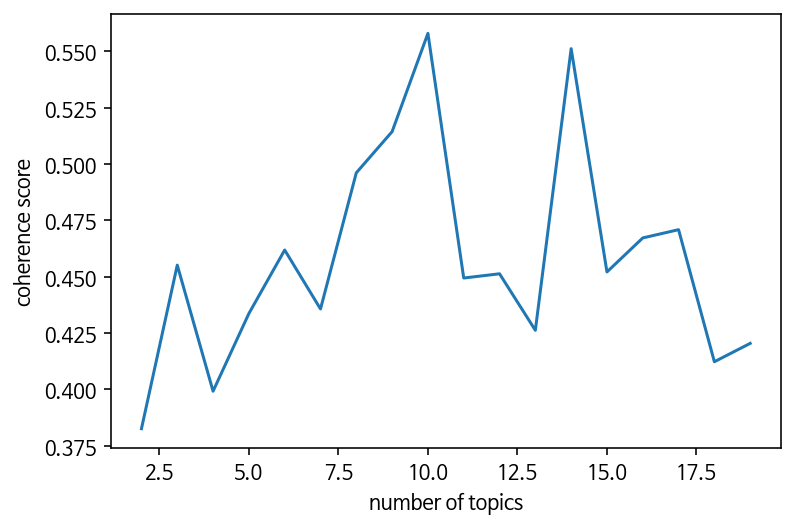

perp: 100%|██████████| 18/18 [01:09<00:00,  3.84s/it]


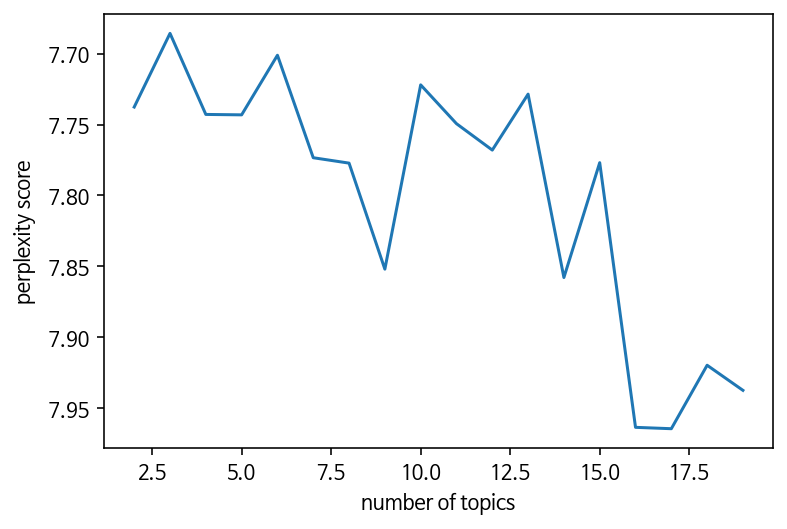

In [62]:
# 말뭉치 만들기 
moonjaein_corpus, moonjaein_dictionary, moonjaein_cleanlist = make_corpus(moonjaein_clean)

# 토픽수 결정 
coh_visual(moonjaein_corpus, moonjaein_dictionary, moonjaein_cleanlist)
perp_visual(moonjaein_corpus, moonjaein_dictionary)

In [64]:
# 토픽모델링 - 사이킷런 LDA 
moonjaein_clean_flat = []

for i in moonjaein_clean: 
    for j in i: 
        moonjaein_clean_flat.append(j)

moonjaein_count_vect = CountVectorizer(max_df = 1.0, 
                                     max_features=1000, 
                                     min_df=10, 
                                     ngram_range=(1,2))
moonjaein_fit_vect = moonjaein_count_vect.fit_transform(moonjaein_clean_flat)

moonjaein_lda = LatentDirichletAllocation(n_components=6, random_state=0)
moonjaein_lda.fit(moonjaein_fit_vect)

moonjaein_feature_names = moonjaein_count_vect.get_feature_names()

display_topics(moonjaein_lda, moonjaein_feature_names, 15)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic # 0
지원 차별 현상 공공기관 직장 비중 근로자 임원 증가 문제 사용 노력 출산 정당 양육비
Topic # 1
신설 처벌 처우 해소 행위 관리 강화 예방 특례법 공정성 경제 전보 무형적 연방유리천장위원회 유리천장위원회
Topic # 2
피해자 성범죄 성희롱 성별 불구 자녀 반면 양립 기구 이유 형법 제도 업무 정보 촬영
Topic # 3
아동 성폭력 능력 지적 비율 가정 제공 설립 현재 양상 적용 가해자 추가 범위 기관
Topic # 4
여성 성폭력범죄 청소년 인사상 대상 자격 과정 채용 감소 사회적 참여율 시정하기 제기 확정 남녀고용평등
Topic # 5
유리천장 보호 범죄 승진 항제 지방자치단체 지속적 불이익 불과 근거 평가 심의 인력 육아휴직 고위직
